Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 287s 9s/step - accuracy: 0.5702 - loss: 0.8263 - val_accuracy: 1.0000 - val_loss: 0.1472
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 318s 9s/step - accuracy: 0.7309 - loss: 0.5381 - val_accuracy: 0.9238 - val_loss: 0.3683
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 308s 9s/step - accuracy: 0.8389 - loss: 0.3918 - val_accuracy: 1.0000 - val_loss: 0.0852
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 276s 9s/step - accuracy: 0.8691 - loss: 0.3294 - val_accuracy: 0.8857 - val_loss: 0.3146
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 323s 9s/step - accuracy: 0.8795 - loss: 0.2919 - val_accuracy: 0.8952 - val_loss: 0.3036


33/33 ━━━━━━━━━━━━━━━━━━━━ 268s 8s/step


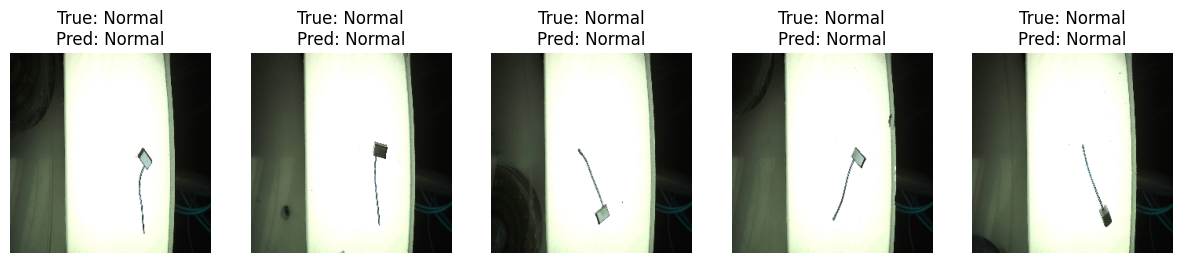

In [ ]:
import numpy as np
import os
import zipfile
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Paths to the ZIP folders
normal_data_zip = '/content/data (2).zip'  # Path to zip file for normal carbon brushes
defect_data_zip = '/content/carbon brush with defect.zip'  # Path to zip file for defective carbon brushes

# Temporary directories to extract the zip contents
normal_data_dir = 'normal_data_extracted'
defect_data_dir = 'defect_data_extracted'

# 1. Unzip the folders
def unzip_folder(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping normal and defective brush datasets
unzip_folder(normal_data_zip, normal_data_dir)
unzip_folder(defect_data_zip, defect_data_dir)

# 2. Preprocessing: Load and preprocess images
def load_images_from_folder(folder, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    labels = []
    for root, _, files in os.walk(folder):
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in color
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))  # Resize to standard dimensions
                img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                if 'defect' in file:  # Assuming defective files have 'defect' in their name
                    labels.append(1)  # Label defective images as 1
                else:
                    labels.append(0)  # Label normal images as 0
    return np.array(images), np.array(labels)

# Load and preprocess the images and labels
normal_images, normal_labels = load_images_from_folder(normal_data_dir)
defect_images, defect_labels = load_images_from_folder(defect_data_dir)

# Combine normal and defective images into one dataset
X = np.concatenate([normal_images, defect_images])
y = np.concatenate([normal_labels, defect_labels])

# 3. Augment defective images to balance the dataset
num_defective_images = defect_images.shape[0]
num_normal_images = normal_images.shape[0]

# Calculate how many defective images need to be generated
num_to_generate = num_normal_images - num_defective_images

# Image augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create directory to save augmented images if not exists
augmented_dir = 'augmented_defects'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

augmented_images = []
for i in range(num_to_generate):
    img = defect_images[i % num_defective_images]  # Loop through defect images if we need to generate more than available
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Generate augmented images (in memory) and save them
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='defect', save_format='jpeg'):
        i += 1
        if i > 2:
            break

# 4. Re-load augmented images into dataset
augmented_defect_images = []
augmented_defect_labels = []
for root, _, files in os.walk(augmented_dir):
    for file in files:
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize to standard dimensions
            img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
            augmented_defect_images.append(img)
            augmented_defect_labels.append(1)  # Label as defect

# Combine original and augmented defect images with normal images
X = np.concatenate([normal_images, defect_images, np.array(augmented_defect_images)])
y = np.concatenate([normal_labels, defect_labels, np.array(augmented_defect_labels)])

# 5. Build ResNet-50 Model for defect detection
def build_resnet50_model(img_height, img_width):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze all layers of ResNet50
    model = models.Sequential([
        base_model,  # Pre-trained ResNet50 as the base
        layers.GlobalAveragePooling2D(),  # Global pooling to reduce the spatial dimensions
        layers.Dropout(0.5),  # Dropout layer to prevent overfitting
        layers.Dense(256, activation='relu'),  # Fully connected layer
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 6. Build and train the ResNet-50 model
model = build_resnet50_model(IMG_HEIGHT, IMG_WIDTH)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X, y, epochs=5, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# 7. Save the trained model
model.save('resnet50_defect_detection_model.h5')

# 8. Visualize predictions
def visualize_predictions(images, labels, predictions, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])  # Show the original image
        title = "Defective" if predictions[i] == 1 else "Normal"
        plt.title(f"True: {['Normal', 'Defective'][labels[i]]}\nPred: {title}")
        plt.axis('off')
    plt.show()

# Make predictions on the entire dataset
predictions = (model.predict(X) > 0.5).astype(int)

# Visualize the first 5 predictions
visualize_predictions(X, y, predictions, num_samples=5)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the model's performance
accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions, zero_division=1)  # Handle undefined precision
recall = recall_score(y, predictions, zero_division=1)  # Handle undefined recall
f1 = f1_score(y, predictions, zero_division=1)  # Handle undefined f1
conf_matrix = confusion_matrix(y, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9032
Precision: 0.8675
Recall: 1.0000
F1 Score: 0.9290
Confusion Matrix:
[[281 101]
 [  0 661]]
